In [1]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import jax
from jax import random, numpy as jnp
from pc2 import Network, Module, Dense, Sequential
import datasets
from PIL import Image
import matplotlib.pyplot as plt
# from clu import metrics
import flax
import flax.linen as nn
import datasets
import numpy.random as npr


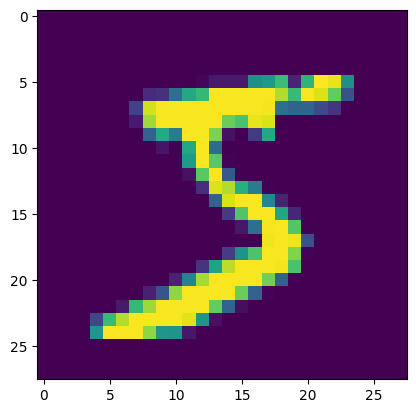

In [2]:
train_images, train_labels, test_images, test_labels = datasets.mnist()
plt.imshow(jnp.reshape(train_images[0], (28,28)))


In [3]:
batch_size = 4096
train_images, train_labels, test_images, test_labels = datasets.mnist()
num_train = train_images.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

def data_stream():
    rng = npr.RandomState(0)
    while True:
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            yield train_images[batch_idx], train_labels[batch_idx]
batches = data_stream()


In [4]:
class MLP(nn.Module):

    @nn.compact
    def __call__(self, x, params=None):
        if params is None:
            x1 = nn.Dense(1024)(x)
        else:
            x1 = nn.Dense(
                features=1024,
                kernel_init=lambda r,s,d:params['Dense_0']['kernel'],
                bias_init=lambda r,s,d:params['Dense_0']['bias'])(x)
        x_1 = self.variable('x_i', 'x_1', lambda s:x1, x1.shape).value
        x2 = nn.tanh(x_1)
        if params is None:
            x2 = nn.Dense(256)(x2)
        else:
            x2 = nn.Dense(
                features=256,
                kernel_init=lambda r,s,d:params['Dense_1']['kernel'],
                bias_init=lambda r,s,d:params['Dense_1']['bias'])(x2)
        x_2 = self.variable('x_i', 'x_2', lambda s:x2, x2.shape).value
        x3 = nn.tanh(x_2)
        if params is None:
            y = nn.Dense(10)(x3)
        else:
            y = nn.Dense(
                features=10,
                kernel_init=lambda r,s,d:params['Dense_2']['kernel'],
                bias_init=lambda r,s,d:params['Dense_2']['bias'])(x3)
        # y = nn.sigmoid(y)
        y = nn.activation.softmax(y)
        # y = nn.activation.softmax(nn.Dense(10)(x_2))
        energy_i = 0.5 * jnp.sum((x_1 - x1) ** 2, axis=-1) + 0.5 * jnp.sum((x_2 - x2) ** 2, axis=-1)
        return y, energy_i

    # def forward(self, x):
    #     theta_0 = self.get_variable('params', 'Dense_0')
    #     x1 = nn.tanh(jnp.einsum('io,bi->bo', theta_0['kernel'], x) + theta_0['bias'])
    #     self.put_variable('x_i', 'x_1', x1)
    #     theta_y = self.get_variable('params', 'Dense_1')
    #     y = jnp.einsum('io,bi->bo', theta_y['kernel'], x1) + theta_y['bias']
    #     y = nn.activation.softmax(y)
    #     return y


model = MLP()

In [5]:
key1, key2 = random.split(random.key(0))
train_size=123
x = train_images[0:train_size]
y = train_labels[0:train_size]
print(x.shape, y.shape)
variables = model.init(key2, x) # Initialization call
jax.tree_util.tree_map(lambda x: x.shape, variables) # Checking output shapes

(123, 784) (123, 10)


{'params': {'Dense_0': {'bias': (1024,), 'kernel': (784, 1024)},
  'Dense_1': {'bias': (256,), 'kernel': (1024, 256)},
  'Dense_2': {'bias': (10,), 'kernel': (256, 10)}},
 'x_i': {'x_1': (123, 1024), 'x_2': (123, 256)}}

In [6]:
model.apply(variables, x)


(Array([[0.10963639, 0.08086108, 0.0792252 , ..., 0.0905846 , 0.08625005,
         0.13718134],
        [0.08564303, 0.0535102 , 0.1259291 , ..., 0.0852263 , 0.1024547 ,
         0.13966812],
        [0.08987457, 0.12355465, 0.09319659, ..., 0.1125367 , 0.0963291 ,
         0.11611517],
        ...,
        [0.09316536, 0.06430121, 0.10110824, ..., 0.10009388, 0.06868123,
         0.19100423],
        [0.09473741, 0.05864696, 0.10425573, ..., 0.08206704, 0.11411878,
         0.131278  ],
        [0.0932291 , 0.10230389, 0.13432024, ..., 0.05894828, 0.10857943,
         0.13367994]], dtype=float32),
 Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

In [7]:
# Same as JAX version but using model.apply().
# @jax.jit
def energy_fn_(theta, x_i, x_batched, y_batched, alpha=1.0):
  def cross_entropy(x, y):
    pred, energy_i = model.apply({'params': theta, 'x_i': x_i}, x)
    cse = -jnp.sum(y * jnp.log(pred), axis=-1)
    result = cse + alpha * energy_i
    # result = 0.5 * jnp.sum((pred - y) ** 2, axis=-1) + alpha * energy_i
    # print(f'result: {result.shape}, {jnp.mean(result, axis=0)}')
    return result, cse, energy_i
  # energy = jnp.mean(jax.vmap(cross_entropy)(x_batched,y_batched), axis=0)
  energy, cse, energy_i = cross_entropy(x_batched,y_batched)
  cse = jnp.mean(cse, axis=0)
  # print(f'cse: {cse.shape} {cse}')
  energy_i = jnp.mean(energy_i, axis=0)
  # print(f'energy_i: {energy_i.shape} {energy_i}')
  energy = jnp.mean(energy, axis=0)
  # print(f'energy: {energy.shape}, {energy}')
  return energy, cse, energy_i

# @jax.jit
def energy_fn(theta, x_i, x_batched, y_batched, alpha=1.0):
  return energy_fn_(theta, x_i, x_batched, y_batched, alpha)[0]

In [8]:
def accuracy(variables, batch):
    inputs, targets = batch
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(model.apply(variables, inputs)[0], axis=1)
    return jnp.mean(predicted_class == target_class)


In [9]:
T = 100 # max IL iterations
eplison = 0.0001 # IL eplison
x_i_lr = 0.5  # Gradient step size for IL
theta_lr = 0.1 # Gradient step size for Theta
theta_grad_fn = jax.value_and_grad(energy_fn, argnums=0)
x_i_grad_fn = jax.value_and_grad(energy_fn, argnums=1)
print(theta_grad_fn, x_i_grad_fn)

@jax.jit
def update_theta(theta, learning_rate, grads):
  theta = jax.tree_util.tree_map(
      lambda p, g: p - learning_rate * g, theta, grads)
  return theta

@jax.jit
def update_x_i(x_i, learning_rate, grads):
  x_i = jax.tree_util.tree_map(
      lambda p, g: p - learning_rate * g, x_i, grads)
  return x_i

# x, y = next(batches)
# variables = model.init(key2, x)

# variables = model.init(key2, train_images, params=theta)
energy, cse, energy_i = energy_fn_(variables['params'], variables['x_i'], x, y)
print(f'energy: {energy}')
print(f'cse: {cse}')
print(f'energy_i: {energy_i}')


<function energy_fn at 0x7fbffd08f060> <function energy_fn at 0x7fbfa84182c0>
energy: 2.335115909576416
cse: 2.335115909576416
energy_i: 0.0


In [10]:
theta = variables['params']

for step in range(501):
  # Perform one gradient update.
  for _ in range(num_batches):
    x, y = next(batches)
    variables = model.init(key2, x, params=theta)
    theta = variables['params']
    x_i = variables['x_i']
    start_energy = energy_fn(theta, x_i, x, y)
    prev_energy = start_energy
    for t, _ in enumerate(range(T)):
      _, grads = x_i_grad_fn(theta, x_i, x, y)
      x_i = update_x_i(x_i, x_i_lr, grads)
      new_energy = energy_fn(theta, x_i, x, y)
      delta = prev_energy - new_energy
      prev_energy = new_energy
      if delta/new_energy < eplison:
        print(f'IL energy: [{start_energy:.3e} => {new_energy:.3e}] ({t})')
        break
      if t == T-1:
        print(f'IL energy: [{start_energy:.3e} => {new_energy:.3e}] [end] ({t})')

    _, grads = theta_grad_fn(theta, x_i, x, y)
    theta = update_theta(theta, theta_lr, grads)


  if step % 1 == 0:
    print(f'Loss step {step}')
    variables = model.init(key2, train_images, params=theta)
    train_acc = accuracy(variables, (train_images, train_labels))
    variables = model.init(key2, test_images, params=theta)
    test_acc = accuracy(variables, (test_images, test_labels))
    print(f"Training set accuracy {train_acc*100:0.2f}%")
    print(f"Test set accuracy {test_acc*100:0.2f}%")


IL energy: [2.316e+00 => 2.315e+00] (0)
IL energy: [2.285e+00 => 2.284e+00] (0)
IL energy: [2.253e+00 => 2.253e+00] (0)
IL energy: [2.232e+00 => 2.231e+00] (0)
IL energy: [2.211e+00 => 2.211e+00] (0)
IL energy: [2.189e+00 => 2.189e+00] (0)
IL energy: [2.167e+00 => 2.167e+00] (0)
IL energy: [2.140e+00 => 2.140e+00] (0)
IL energy: [2.117e+00 => 2.117e+00] (0)
IL energy: [2.099e+00 => 2.099e+00] (0)
IL energy: [2.088e+00 => 2.088e+00] (0)
IL energy: [2.064e+00 => 2.064e+00] (0)
IL energy: [2.043e+00 => 2.043e+00] (0)
IL energy: [2.021e+00 => 2.020e+00] (0)
IL energy: [1.995e+00 => 1.968e+00] [end] (99)
Loss step 0
Training set accuracy 49.15%
Test set accuracy 48.95%
IL energy: [1.977e+00 => 1.977e+00] (0)
IL energy: [1.964e+00 => 1.964e+00] (0)
IL energy: [1.946e+00 => 1.946e+00] (0)
IL energy: [1.935e+00 => 1.935e+00] (0)
IL energy: [1.913e+00 => 1.912e+00] (0)
IL energy: [1.885e+00 => 1.884e+00] (0)
IL energy: [1.885e+00 => 1.885e+00] (0)
IL energy: [1.868e+00 => 1.868e+00] (0)
IL ener

In [ ]:
a = jax.random.normal(key1, (3,3))
b = jax.random.normal(key1, (3,3))
a * b

Array([[6.8150144e+00, 1.1460138e-03, 1.1801200e+00],
       [2.1912851e+00, 2.3726006e+00, 1.1289402e+00],
       [2.9349127e-01, 2.8977572e-04, 7.4130140e-02]], dtype=float32)

In [ ]:
print(model.scope)

None


In [ ]:
print(variables['x_i'])
print(variables['x_i']['x_1'].shape)
print(variables['x_i']['x_2'].shape)

{'x_1': Array([[-0.13462605, -0.3278432 ,  0.22782673, ..., -0.10996187,
        -0.49576125,  0.2525089 ],
       [ 0.02520173, -0.22533576,  0.7370963 , ..., -0.4481546 ,
        -0.02872543,  0.38858265],
       [ 0.10196313,  0.07504214, -0.06939081, ...,  0.11857884,
        -0.21023458,  0.27247092],
       ...,
       [ 0.00991802,  0.08777118, -0.07607331, ..., -0.03389303,
        -0.42004925,  0.45156288],
       [ 0.31259665, -0.01424194,  0.6128926 , ..., -0.3326202 ,
        -0.1322913 , -0.15132794],
       [ 0.32569477, -0.5153029 ,  0.20282543, ..., -0.22639666,
        -0.20922866,  0.07548092]], dtype=float32), 'x_2': Array([[-0.39323556,  1.7077905 , -0.33184367, ...,  0.21103896,
        -0.05986749,  0.72051615],
       [ 0.1705095 ,  2.6917632 , -0.01869105, ...,  0.21125521,
        -0.04514058,  1.1818498 ],
       [-0.18432917,  0.8543403 ,  0.21080086, ..., -0.02238091,
        -0.43819115,  0.21665443],
       ...,
       [ 0.06171044,  2.8494017 ,  0.1912569